In [1]:
from __future__ import division

import pandas as pd
import numpy as np
#import html2text
from datetime import date
import random
import os

#Packages for pulling text data 
from urllib.request import urlopen  # the lib that handles the url stuff
from bs4 import BeautifulSoup
import pandas.io.data as web
from pandas.tseries.offsets import BDay

#Packages for text data processing
import nltk, re, pprint
#nltk.download()
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

#Packages for statistical learning 
from sklearn.preprocessing import normalize as Normal
from sklearn import svm
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline

import imp

import Text_Analytics as TA

C:\Users\ziyi\Anaconda3\lib\site-packages\pandas\io\data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
#from imp import reload 
imp.reload(TA)

<module 'Text_Analytics' from 'C:\\Users\\ziyi\\Desktop\\Inde project\\Independent Study Anseri-20170120T004329Z\\Independent Study Anseri\\Code repo\\Text_Analytics.py'>

In [3]:
#Setup working directory 
os.chdir("C:/Users/ziyi/Desktop/Inde project/Independent Study Anseri-20170120T004329Z/Independent Study Anseri")

#Download Data 
df=pd.read_excel('8K data/Price_Info.xlsx')
MID_index=pd.read_excel("8K data/MID Index.xlsx")

In [4]:
MID_index.Ticker=MID_index.Ticker.apply(lambda x:x.split(" ")[0])
Tik_Name=MID_index[MID_index["GICS Sector"]=="Information Technology"][["Ticker","Name","Market Cap"]]
Tik_Name.Name=Tik_Name.Name.apply(lambda x:x.upper())

In [5]:
#Drop Companies without price information
to_drop=["VERSUM MATERIALS INC","KEYSIGHT TECHNOLOGIES INC",'CDK GLOBAL INC',
         'KNOWLES CORP','SCIENCE APPLICATIONS INTERNATIONAL CORP']

to_drop_index=[]
for i,row in Tik_Name.iterrows():
    if row["Name"] in to_drop:
        to_drop_index.append(i)
to_drop_index

[58, 134, 179, 283, 344]

In [6]:
Tik_Name=Tik_Name.drop(to_drop_index)
Tik_Name.shape

(62, 3)

In [8]:
Tik_Name["Weight"]=Tik_Name["Market Cap"]/sum(Tik_Name["Market Cap"])
Tik_Name

,Ticker,Name,Market Cap,Weight
8,MPWR,MONOLITHIC POWER SYSTEMS INC,3462565376,0.011873
9,BDC,BELDEN INC,3087077888,0.010586
10,ACXM,ACXIOM CORP,2208818432,0.007574
13,WEX,WEX INC,4759351296,0.016320
15,PAY,VERIFONE SYSTEMS INC,2156781056,0.007396
18,MMS,MAXIMUS INC,3835664896,0.013153
20,WBMD,WEBMD HEALTH CORP,1876967936,0.006436
23,LOGM,LOGMEIN INC,5008748032,0.017175
33,CLGX,CORELOGIC INC/UNITED STATES,3300080384,0.011316
36,DST,DST SYSTEMS INC,3740173312,0.012825


In [14]:
Tik_Name.to_csv("8K data/Index_Info.csv",index_col=0)

In [7]:
df.index=df["Date"]
df=df.drop("Date",axis=1)
df=df.loc[:,Tik_Name["Ticker"]]
df.shape

(1028, 62)

In [8]:
df.head()

,MPWR,BDC,ACXM,WEX,PAY,MMS,WBMD,LOGM,CLGX,DST,...,BRCD,MANH,CREE,JCOM,CVLT,NTCT,SYNA,DDD,SNX,NSR
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,22.830000,46.150002,18.370001,76.519997,29.750000,64.709999,15.20,23.299999,27.450001,62.020000,...,5.71,63.029999,34.720001,31.790001,72.059998,26.730000,30.430000,55.780003,35.139999,43.680000
2013-01-03,22.950001,45.680000,18.190001,76.089996,30.309999,63.930000,15.28,22.930000,27.330000,61.750000,...,5.44,61.790001,34.570000,31.690001,70.290001,26.350000,30.440001,56.969999,35.049999,43.180000
2013-01-04,22.580000,46.400002,18.190001,76.330002,30.830000,64.919998,15.51,23.150000,27.780001,62.720001,...,5.50,61.740002,34.360001,31.879999,71.650002,26.950001,30.750000,58.840004,35.259998,43.080002
2013-01-07,22.180000,46.299999,18.040001,76.129997,31.500000,64.230003,15.36,23.549999,27.490000,62.419998,...,5.50,62.240002,31.799999,31.750000,68.889999,25.990000,30.190001,60.670006,35.520000,42.950001
2013-01-08,22.309999,46.240002,18.020000,76.750000,30.950001,63.990002,14.95,23.150000,27.340000,62.450001,...,5.36,63.189999,31.440001,31.840000,67.510002,26.740000,29.860001,58.649998,35.230000,42.660000


In [9]:
Price_ts_Info=np.dot(df.as_matrix(),Tik_Name["Market Cap"].as_matrix())/Tik_Name["Market Cap"].sum()

In [10]:
Price_ts_Info=pd.DataFrame({"Price":Price_ts_Info},index=df.index)

In [11]:
Return_Info=np.zeros(Price_ts_Info.shape[0])
for i in range(1,Price_ts_Info.shape[0]):
    Return_Info[i]=np.log(Price_ts_Info.iloc[i,0])-np.log(Price_ts_Info.iloc[i-1,0])

In [12]:
Price_ts_Info["Return"]=Return_Info

In [13]:
Price_ts_Info=Price_ts_Info[Price_ts_Info.index<"2016-12-31"]

In [14]:
Price_ts_Info.head()

,Price,Return
Date,,
2013-01-02,34.872865,0.000000
2013-01-03,34.601248,-0.007819
2013-01-04,34.678329,0.002225
2013-01-07,34.532513,-0.004214
2013-01-08,34.441307,-0.002645


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C951BA8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000CAB1C18>], dtype=object)

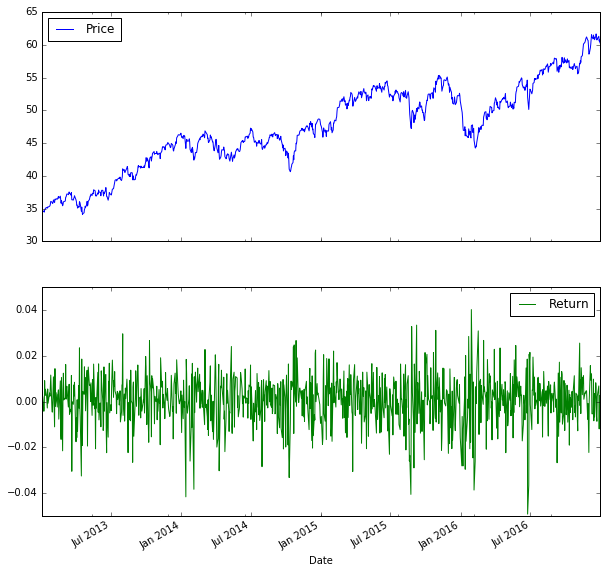

In [15]:
Price_ts_Info.plot.line(subplots=True, figsize=(10, 10))

In [16]:
Price_ts_Info.to_csv("8K data/Price_ts_Info.csv",index_col=0)